# AMEX Default Prediction

## 1. Set up

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import pyarrow
from sklearn import preprocessing
import math

## 2, Exploratory Analysis
This notebook just explores the variables, to make better decisions for preprocessing later on

In [2]:
from sklearn.model_selection import train_test_split


In [3]:
# global parameters
SAMPLE = True

# load parquet data
data = pd.read_parquet('dataset/train.parquet')
raw_labels = pd.read_csv('dataset/train_labels.csv')

# use a smaller subset for fast pipeline during testing
if SAMPLE:
    sample = raw_labels['customer_ID'][:10000]
    data = data[data['customer_ID'].isin(sample)]

In [4]:
# check missing values
null= round(((data.isna().sum()+(data==-1).sum())/data.shape[0]*100),2).sort_values(ascending=False).astype(str)+('%')
null= pd.DataFrame({'Missing:': null})
null.head(30)

,Missing:
D_87,99.94%
D_88,99.87%
D_108,99.47%
D_110,99.35%
D_111,99.35%
B_39,99.31%
D_73,98.78%
B_42,98.71%
D_138,96.44%
D_134,96.44%


### 2.1 Categorical data
It makes sense to treat categorical data differently. Means do not make sense when data is categorical. Instead, we should use modes or quartiles

In [6]:
# see portion of missing values
from src.constants import categorical_variables

# check missing values for categorical data
null= round(((data[categorical_variables]==-1).sum()/data.shape[0]*100),2).sort_values(ascending=False).astype(str)+('%')
null= pd.DataFrame({'Missing:': null})
null.head(30)
# Note: all of these are marked by -1, and not by np.nan

,Missing:
D_66,88.92%
D_64,4.1%
D_68,3.99%
D_114,3.23%
D_116,3.23%
D_117,3.23%
D_120,3.23%
D_126,2.14%
B_30,0.04%
B_38,0.04%


Thoughts: 
- Missing might just be treated as zeros here
- Some of these are multi-class, its hard to know if order matters for the categories here

### discover categorical variables
The number of categorical columns hinted at by online sources seem a bit insufficient. To identify categorical variables, we check for two things.
1) if there are less than 5 unique values for that column, its likely to be categorical
2) if all values are integers, its likely to be categorical.

In [28]:

multi_class = []
binary = []
single_class = []
for col in data.columns:
    x = list(data[col].unique())

    if len(x) < 10:
        # remove missing
        if np.nan in x:
            x.remove(np.nan)
        if -1 in x:
            x.remove(-1)

        # check if all values are integers
        is_cat = True
        for v in x:
            if abs(v%1) > 1e-6:
                is_cat = False
                break
        
        if is_cat and len(x) <= 1:
            single_class.append(col)
        if is_cat and len(x) <= 2:
            binary.append(col)
        elif is_cat and len(x) < 10:
            multi_class.append(col)

#print them out. These are copied to constants
print(f"binary_columns = {binary}")
print(f"multiclass_columns = {multi_class}")


binary columns = ['R_2', 'S_6', 'R_4', 'D_66', 'R_15', 'S_18', 'D_86', 'D_87', 'B_31', 'R_19', 'B_32', 'S_20', 'R_21', 'B_33', 'R_22', 'R_23', 'D_93', 'D_94', 'R_24', 'R_25', 'D_96', 'D_103', 'D_109', 'D_114', 'D_116', 'D_120', 'D_127', 'D_129', 'R_28', 'D_135', 'D_137', 'D_139', 'D_140', 'D_143']
multiclass columns = ['D_51', 'D_63', 'D_64', 'D_68', 'B_22', 'D_79', 'R_10', 'R_11', 'D_82', 'B_30', 'R_18', 'D_91', 'D_92', 'B_38', 'D_108', 'D_111', 'D_117', 'D_123', 'D_125', 'D_126', 'D_136', 'D_138']


#### 2.1.1 Binary Columns

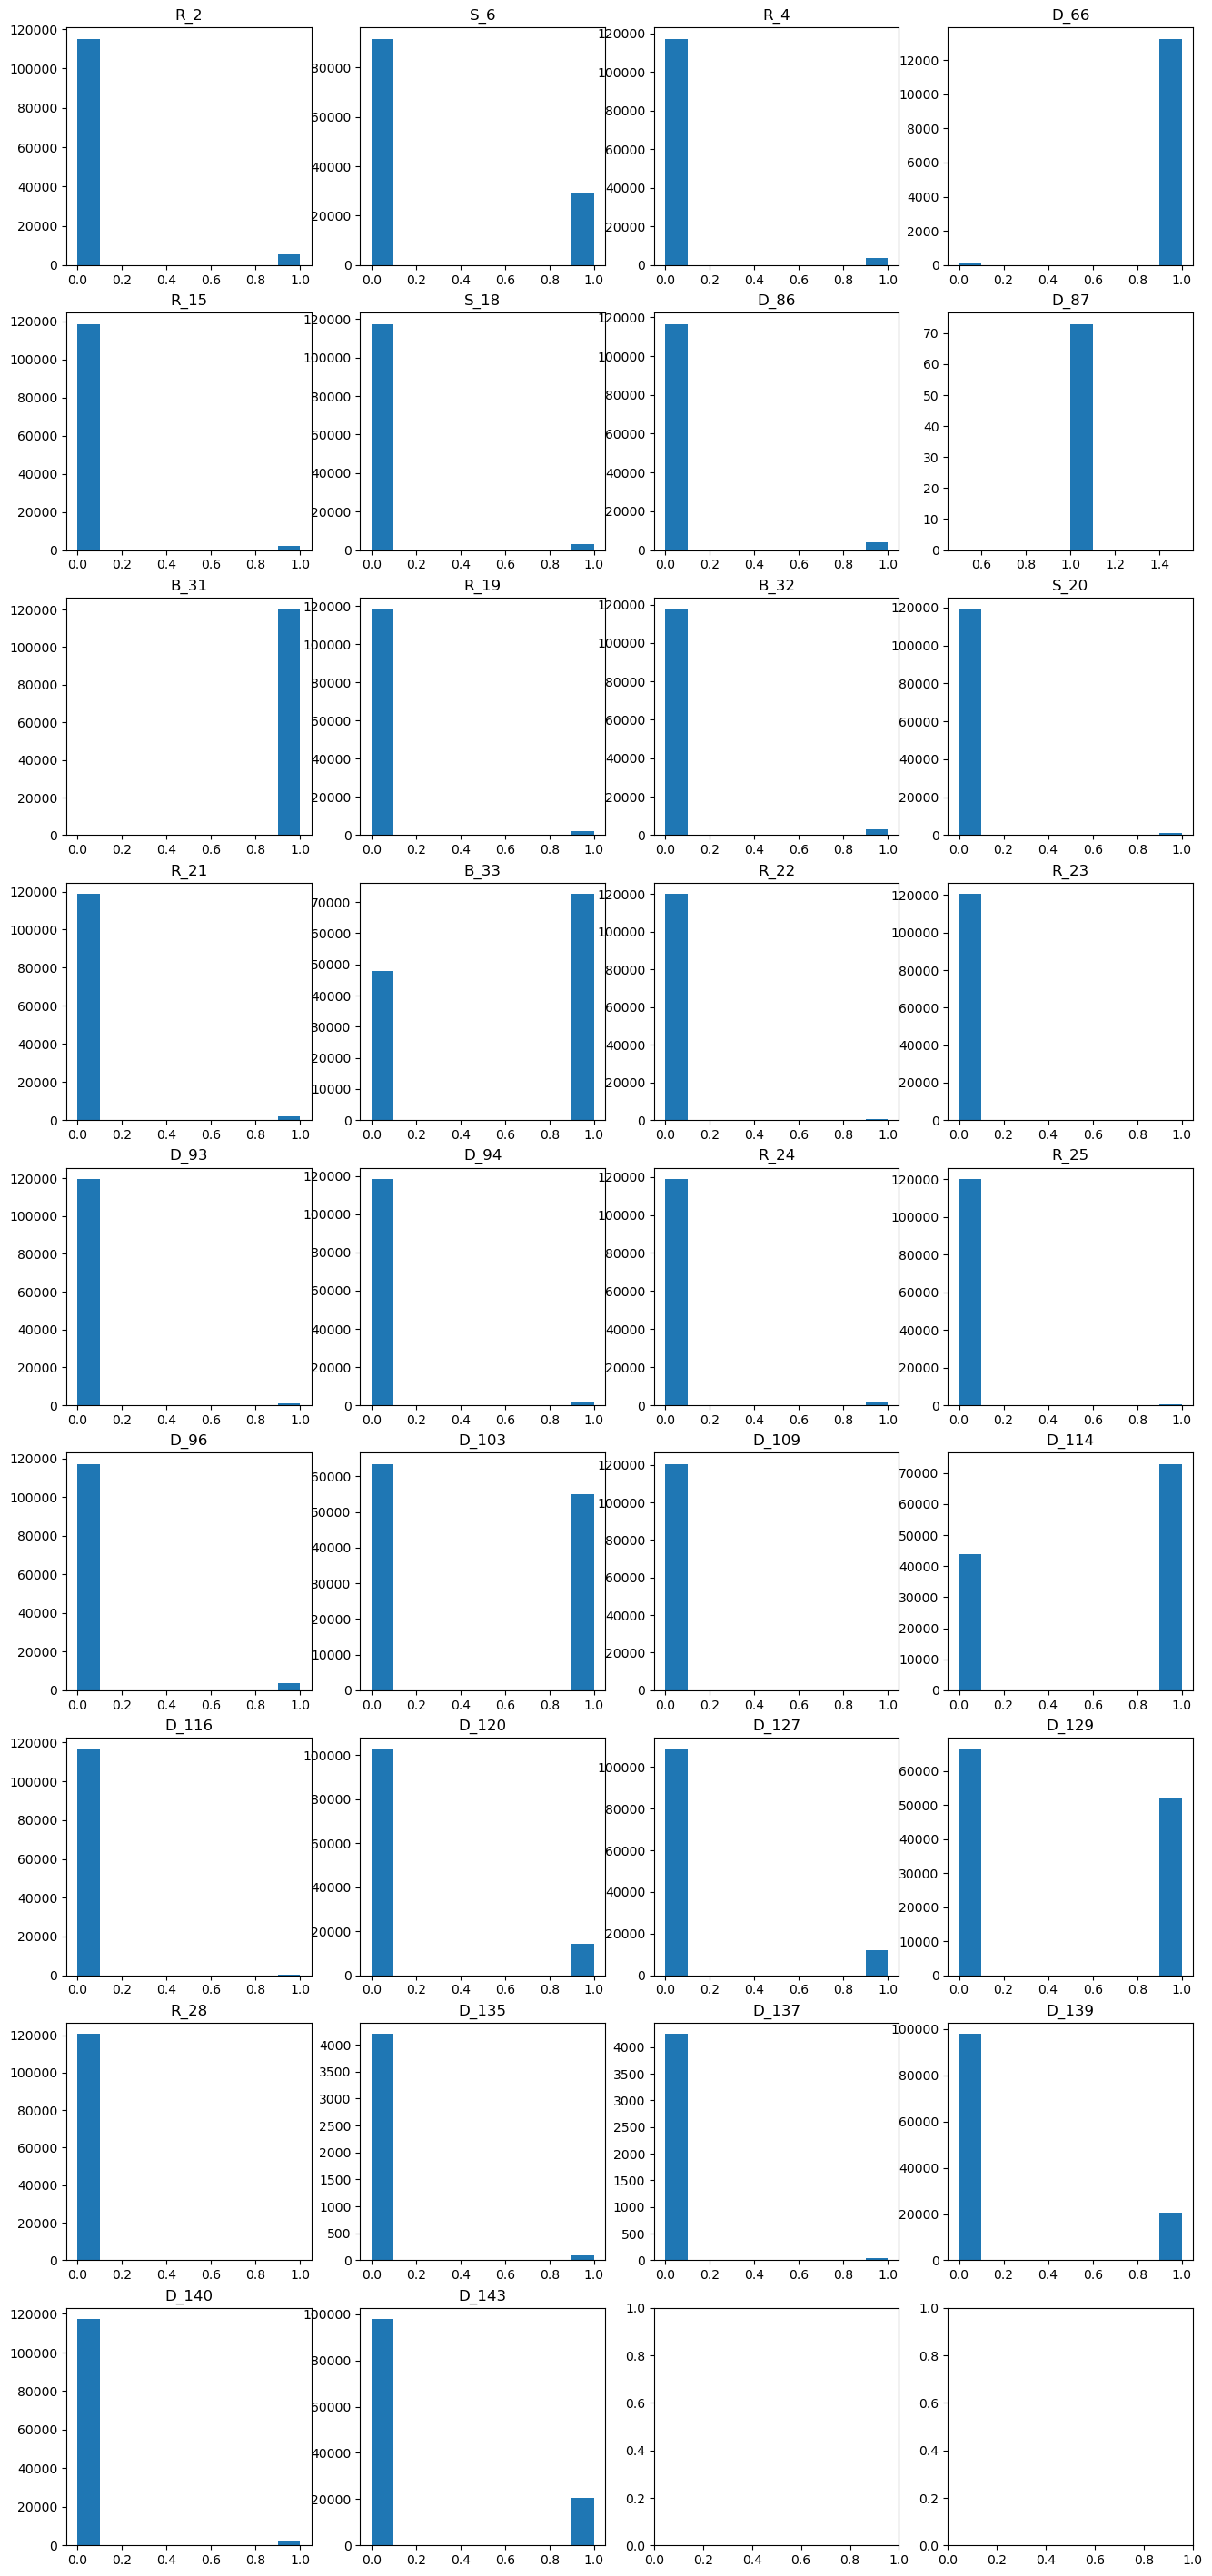

In [29]:
vars_to_plot = binary
# create grid of subplots
n_cols = 4
n_rows = math.ceil(len(vars_to_plot)/n_cols)
fig, ax = plt.subplots(n_rows, n_cols, figsize = [4*n_cols,4*n_rows])

for index, var in enumerate(vars_to_plot):
    i = index//n_cols
    j = index%n_cols
    ax[i,j].set_title(var)
    ax[i,j].hist(data[[var]].replace(-1, np.nan) ) 

#### 2.1.2 Multiclass Categorical columns

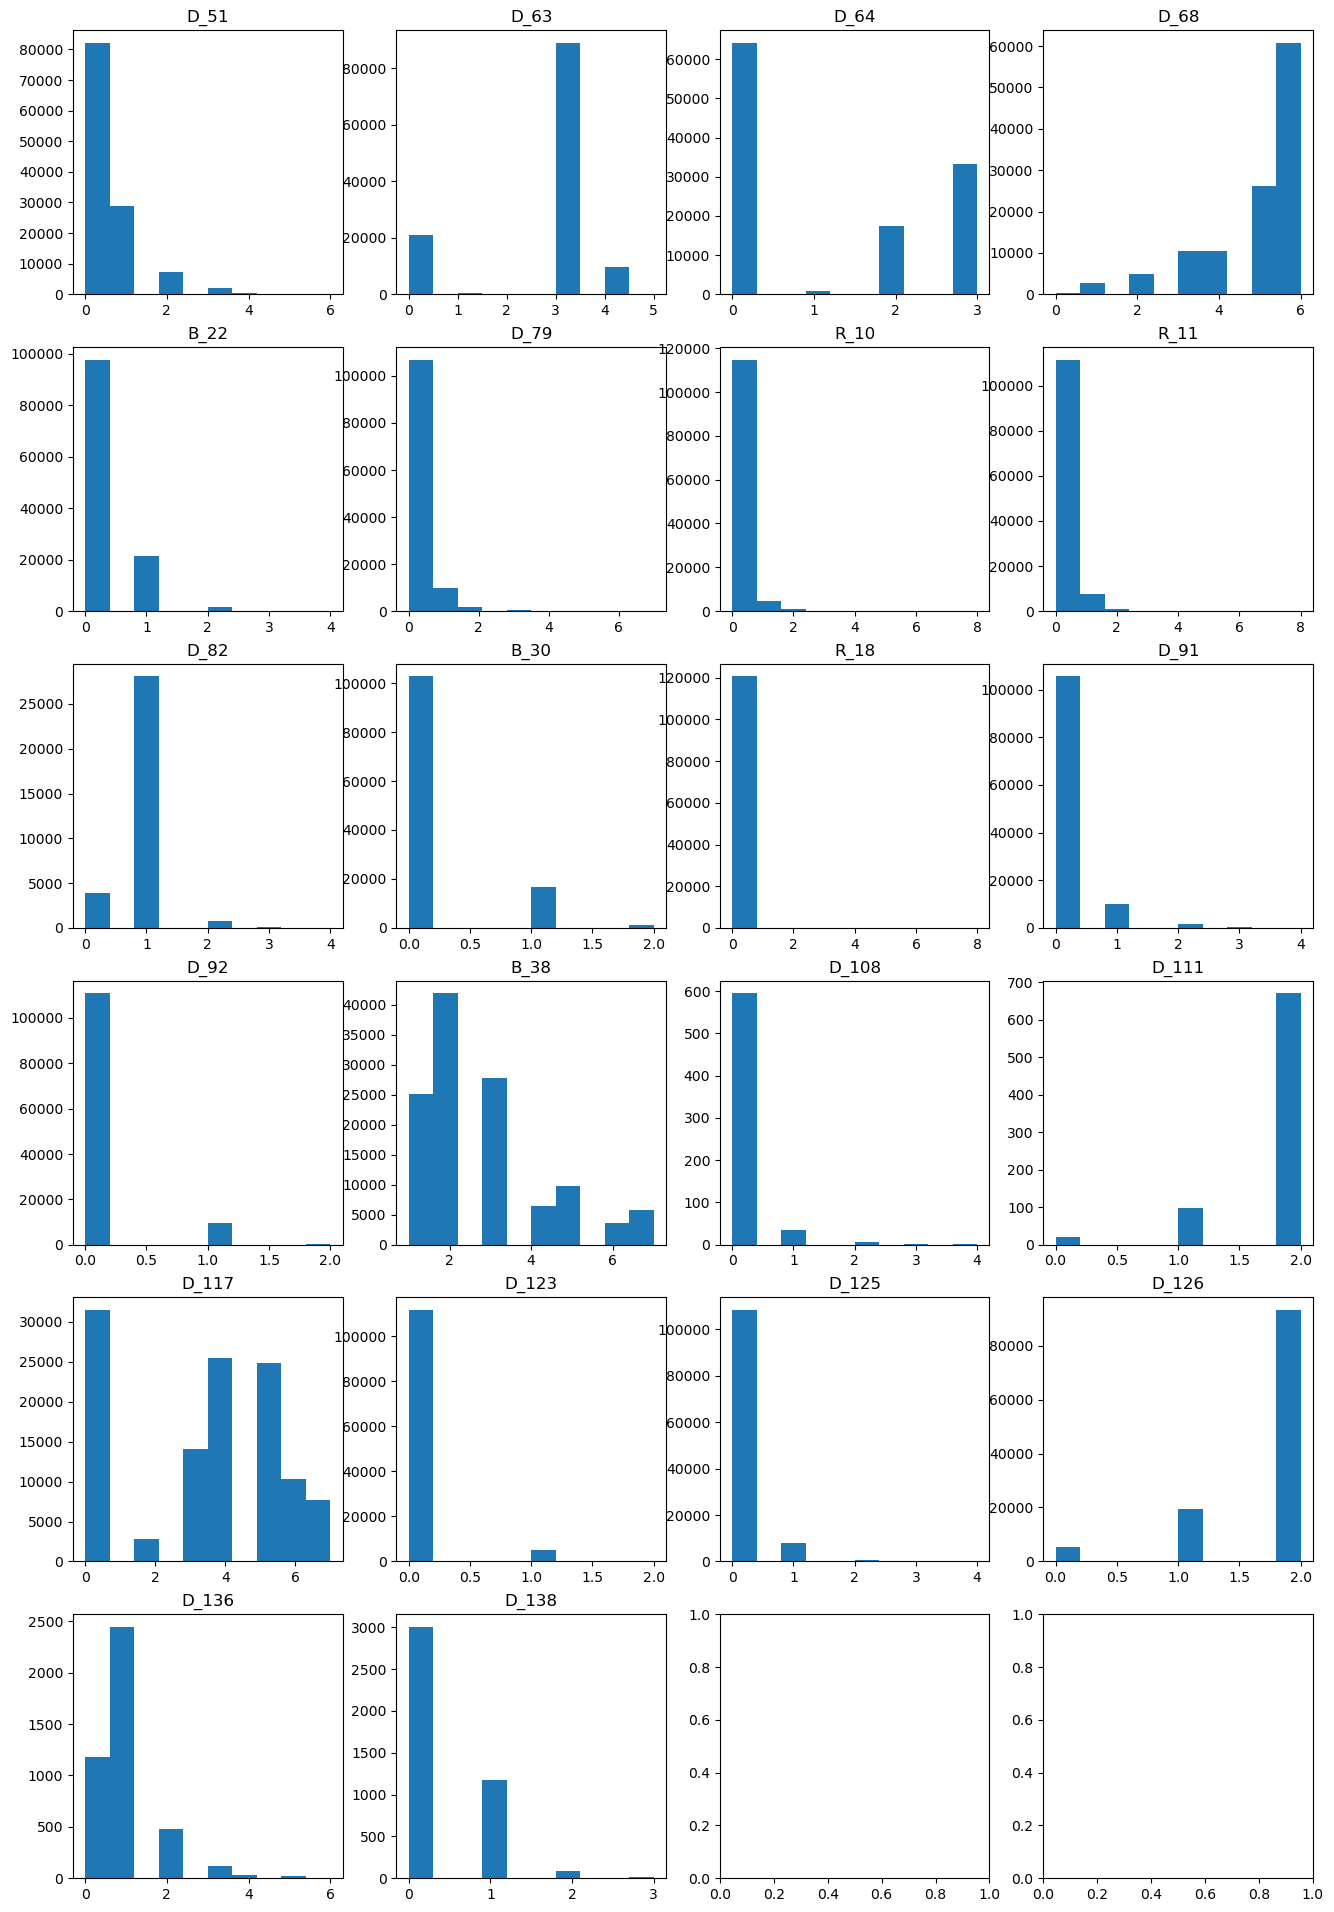

In [30]:
vars_to_plot = multi_class
# create grid of subplots
n_cols = 4
n_rows = math.ceil(len(vars_to_plot)/n_cols)
fig, ax = plt.subplots(n_rows, n_cols, figsize = [4*n_cols,4*n_rows])

for index, var in enumerate(vars_to_plot):
    i = index//n_cols
    j = index%n_cols
    ax[i,j].set_title(var)
    ax[i,j].hist(data[[var]].replace(-1, np.nan) ) 

### Continuous variables